### Step 52. GPU 지원

이번에는 쿠파이를 활용하여 GPU를 활용해서 신경망을 계산해볼 것이다. 먼저, 쿠파이를 사용할 때 알아야할 몇 가지를 짚고 넘어가보자.

* numpy 배열을 cupy 배열로 변환할 수 있고, 반대로 cupy 배열을 numpy 배열로 변환할 수 있다.
```python
n = np.array([1, 2, 3])
c = cp.asarray(n) # numpy 배열인 n이 cupy 배열로 변환되었다.
n = cp.asnumpy(c) # cupy 배열인 c가 numpy 배열로 변환되었다.
```
* cp.get_array_module(x)은 x에 적합한 모듈을 돌려준다.
```python
 x = np.array([1, 2, 3])
 xp = cp.get_array_module(x)
 assert xp == np

 x = cp.array([1, 2, 3])
 xp = cp.get_array_module(x)
 assert xp == cp
```

이제 Dezero에서 cupy를 사용할 수 있도록 지원하겠다.

In [ ]:
def as_numpy(x):
  if isinstance(x, Variable):
    x = x.data

  if np.isscalar(x):
    return np.array(x)
  elif isinstance(x, np.ndarray):
    return cp.asnumpy(x)

def as_cupy(x):
  if isinstance(x, Variable):
    x = x.data

  if not gpu_enable:
    raise Exception('쿠파이(Cupy)를 로드할 수 없습니다. 쿠파이를 설치해주세요!')
  return cp.asarray(x)

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install cupy

import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero.dataloaders import DataLoader
from dezero import datasets
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set = datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if dezero.cuda.gpu_enable:
  train_loader.to_gpu()
  model.to_gpu()

for epoch in range(max_epoch):
  start = time.time()
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  elapsed_time = time.time() - start
  print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
      epoch + 1, sum_loss / len(train_set), elapsed_time
  ))

  Using cached cupy-9.4.0.tar.gz (1.7 MB)
  Created wheel for cupy: filename=cupy-9.4.0-cp37-cp37m-linux_x86_64.whl size=93340012 sha256=77168a3c6b1b10603f5b8daa1de4d87b6bd065df54432a42f96cb1b0fbbd90a5
  Stored in directory: /root/.cache/pip/wheels/46/44/a0/44280e968e0e9280b8053c0db1ba2635fccc53f3a6aa6eb5e2
Successfully built cupy
epoch: 1, loss: 1.9204, time: 11.1081[sec]
epoch: 2, loss: 1.2900, time: 11.1054[sec]
epoch: 3, loss: 0.9275, time: 11.1762[sec]
epoch: 4, loss: 0.7417, time: 11.2173[sec]
epoch: 5, loss: 0.6365, time: 11.1788[sec]


### Step 53. 모델 저장 및 읽어오기

이번 단계에서는 모델이 가지는 매개변수를 외부 파일로 저장하고, 다시 읽어오는 기능을 만든다. 이런 기능이 있다면, 학습 중인 모델의 '스냅샷'을 저장하거나, 이미 학습된 매개변수를 읽어와서 추론만 수행할 수 있다.

먼저 `np.save()`와 `np.load` 함수를 알아보자.

In [ ]:
import numpy as np

x = np.array([1, 2, 3])
np.save('test.npy', x)

x = np.load('test.npy')
print(x)

[1 2 3]


이어서 여러개의 ndarray 인스턴스를 저장하고 읽어오는 방법을 살펴보겠다. 이 경우에는 `np.savez()`와 `np.load()` 함수를 사용한다.

In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])

np.savez('test.npz', x1=x1, x2=x2)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


이외에도 `np.savez('test.npz', **data)` 코드로 데이터를 저장할 수 있다. 이 코드에서처럼 딕셔너리 타입의 인수를 전달할 때 **data와 같이 앞에 별표 두 개를 붙여주면 딕셔너리가 자동으로 전개되어 전달된다.

In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])
data = {'x1':x1, 'x2':x2}

np.savez('test.npz', **data)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


이번에는 Layer 계층에 Layer이 가지고 있는 모든 매개변수를 dict 형태로 출력하는 함수를 만든다.

```python
class Layer:
  ...

  def _flatten_params(self, param_dict, parent_key=''):
    for name in self._params:
      obj = self.__dict__[name]
      key = parent_key + '/' + name if parent_key else name

      if isinstance(obj, Layer):
        obj._flatten_params(params_dict, key)
      else:
        params_dict[key] = obj
```

이어서, Layer 클래스의 매개변수를 외부 파일로 저장하는 `save_weights` 함수를 만든다. 또한, 외부파일을 일거서, 매개변수에 값을 채워넣는 'load_weights' 함수도 구현해 볼것이다.

```python
class Layer:
  ...

  def save_weights(self, path):
    self.to_cpu()

    params_dict = {}
    self._flatten_parms(params_dict)
    array_dict = {key: param.data for key, param in params_dict.items() if param is not None}

    try:
      np.savez_compressed(path, **array_dict)
    except (Exception, KeyboardInterrupt) as e:
      if os.path.exists:
        os.remove(path)
      raise

  def load_weigths(self, path):
    npz = np.load(path)
    params_dict = {}
    self._flatten_params(params_dict)
    for key, param in params_dict.items():
      param.data = npz[key]
```

이제 이 기능들을 사용해서 모델을 학습해보자.

In [ ]:
import os
import dezero
import dezero.functions as F
from dezero import optimizers, datasets
from dezero.dataloaders import DataLoader
from dezero.models import MLP


max_epoch = 3
batch_size = 100

train_set = datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('my_mlp.npz'):
  model.load_weighs('my_mlp.npz')

for epoch in range(max_epoch):
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  print('epoch: {}, loss: {:.4f}'.format(epoch+1, sum_loss / len(train_set)))

model.save_weights('my_mlp.npz')

epoch: 1, loss: 1.9131
epoch: 2, loss: 1.2825
epoch: 3, loss: 0.9243


### Step 54. 드롭아웃과 테스트모드

신경망 학습에서는 과대적합이 자주 문제가 된다. 다음은 과대적합이 일어나는 주요 원인이다.
* 훈련 데이터가 적음
* 모델의 표현력이 지나치게 높음

첫 번째 원인 때문이라면, 데이터를 더 확보하거나 데이터 수를 인위적으로 늘리는 데이터 확장(Data argumentation)을 이용하면 효과적이다. 두 번째 원인에는 가중치 감소(Weight Decay), 드롭아웃(Dropout), 배치정규화(Batch Normalization) 등이 유효하다.

이번단계에서는 그중에서도 가장 많이 사용되는 역 드롭아웃(Inverted Dropout)을 구현해보겠다.

In [ ]:
import dezero
from dezero import as_variable
from dezero import cuda

def dropout(x, dropout_ratio=0.5):
  x = as_variable(x)

  if dezero.core.Config.train:
    xp = cuda.get_array_module(x)

    mask = xp.random.rand(*x.shape) > dropout_ratio
    scale = xp.array(1 / (1 - dropout_ratio)).astype(x.dtype)
    out = x * mask * scale
    return out
  return x

드롭아웃을 사용하려면 학습 단계인지, 테스트 단계인지 구분해야 하는데, 이를 위해서 `Config` 클래스에 `train` 변수를 추가하고, `det test_mode()` 함수를 구현한다.

```python
class Config:
  enable_backprop = True
  train = True

def test_mode():
  return using_config('train', False)
```

In [ ]:
import numpy as np
from dezero.core import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

y = dropout(x)
print(y)

with test_mode():
  y = dropout(x)
  print(y)

[1. 1. 1. 1. 1.]
variable([2. 0. 0. 2. 0.])
variable([1. 1. 1. 1. 1.])


### Step 55. CNN 메커니즘



In [ ]:
# 합성곱 연산의 결과 사이즈를 계산해준다.
def get_conv_outsize(input_size, kernel_size, stride, pad):
  return (input_size + 2 * pad - kernel_size) // stride + 1

H, W = 4, 4
KH, KW = 3, 3
SH, SW = 1, 1
PH, PW = 1,1 

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


합성곱을 계산할 때는 입력 데이터를 `im2col` 함수를 사용해서 행렬(2차원 텐서)로 변환한다. 이렇게 하면 합성곱을 행렬곱으로 계산할 수 있어, 행렬 라이브러리가 제공하는 최적화된 해택을 누릴 수 있다.

In [ ]:
import numpy as np
import dezero.functions_conv as F

x1 = np.random.randn(1, 3, 7, 7)
col1 = F.im2col_array(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

(9, 75)


위 함수를 사용해서, 실제 합성곱을 계산하는 함수를 구현해보자.

In [ ]:
def conv2d_simple(x, W, b=None, stride=1, pad=0):
  x, W = as_variable(x), as_variable(W)

  Weight = W
  N, C, H, W = x.shape
  OC, C, KH, KW = Weight.shape
  SH, SW = pair(stride)
  PH, PW = pair(pad)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, (KH, KW), stride, pad, to_matrix=True)
  Weight = Weight.reshape(OC, -1).transpose()
  t = linear(col, Weight, b)
  y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)
  return y

위 함수를 활용해서, Conv2d 계층을 구현해보겠다.

In [ ]:
class Conv2d(Layer):
  def __init__(self, out_channels, kernel_size, stride=1, pad=0, nobias=False, dtype=np.float32, in_channels=None):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.pad = pad
    self.dtype = dtype

    self.W = Parameter(None, name='W')
    if in_channels is not None:
      self._init_W()

    if no_bias:
      self.b = None
    else:
      self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')

  def _init_W(self, xp=np):
    C, OC = self.in_channels, self.out_channels
    KH, KW = pair(self.kernel_size)
    scale = xp.sqrt(1 / C * KH * KW)
    W_data = xp.random.randn(OC, C, KH, KW).astype(dtype) * scale
    self.W.data = W_data

  def forward(self, x):
    if self.W.data is None:
      self.in_channels = x.shape[1]
      xp = cuda.get_array_module(x)
      self._init_W(xp)

    y = F.conv2d_simple(x, self.W, self.b, self.stride, self.pad)
    return y

이어서 풀링층을 계산해보겠다.

풀링은 가로, 세로 공간을 작게 만드는 연산이다. Max 풀링, Average 풀링 등이 있으며, Max 풀링은 대상 영역에서 최댓값을 취하는 연산인 반면, Average 풀링은 대상 영역의 평균을 계산한다. 이미지 인식 분야에서는 보통 Max 풀링을 사용한다.

풀링에는 다음과 같은 특성이 있다.
* **학습하는 매개변수가 없다.**<br>
풀링층은 합성곱층과 달리, 학습하는 매개변수가 없다. 풀링은 대상 영역에서 최댓값을 취하는 처리만 하면 끝이기 때문이다.
* **채널 수가 변하지 않는다.**<br>
* **미세한 위치 변화에 영향을 덜 받는다.**<br>
입력 데이터의 차이가 크지 않으면 풀링 결과도 크게 달라지지 않는다. 이를 입력 데이터의 미세한 차이에 강건하다고도 표현한다.


In [ ]:
def pooling_simple(x, kernel_size, stride=1, pad=0):
  x = as_variable(x)

  N, C, H, W = x.shape
  KH, KW = pair(kernel_size)
  PH, PW = pair(pad)
  SH, SW = pair(stride)
  OH = get_conv_outsize(H, KH, SH, PH)
  OW = get_conv_outsize(W, KW, SW, PW)

  col = im2col(x, kernel_size, stride, pad, to_matirx=True)
  col = col.reshape(-1, KH * KW)
  y = col.max(axis=1)
  y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
  return y

### Step 58. 대표적인 CNN(VGG16)

VGG는 2014년 ILSVRC 대회에서 준우승한 모델이다. 이번단계에서는 VGG 모델 중 하나인 VGG16 모델을 Dezero로 구현해볼것이다.

In [ ]:
import dezero.functions as F
import dezero.layers as L
from dezero.models import Model


class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/releases/download/v0.1/vgg16.npz'

    def __init__(self, pretrained=False):
        super().__init__()
        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096)
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)

        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x

VGG16 모델의 계산 그래프를 그려보자.

In [ ]:
from dezero.models import VGG16
import numpy as np

model = VGG16(pretrained=True)
x = np.random.randn(1, 3, 224, 224).astype(np.float32)
model.plot(x)

 위에서 구현한 VGG16을 사용하여, 이미지를 얼마나 잘 인식하는지 살펴보겠다. 우선, 샘플 이미지를 읽어보자.

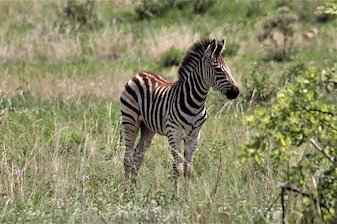

In [ ]:
import dezero
from PIL import Image
from IPython import display

url = 'https://raw.githubusercontent.com/WegraLee/deep-learning-from-scratch-3/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
display.Image(img_path)

이제, 미리 학습된 가중치를 활용하여 사진 인식을 수행해보자.

In [ ]:
from dezero import datasets

img = Image.open(img_path)
x = VGG16.preprocess(img)
x = x[np.newaxis]

model = VGG16(pretrained=True)
with dezero.core.test_mode():
  y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = ImageNet.labels()
print(labels[predict_id])

Downloading: imagenet1000_clsidx_to_labels.txt
[##############################] 100.00% Done
zebra


### Step 59. RNN을 활용한 시계열 데이터 처리





In [ ]:
class RNN(Layer):
  def __init__(self, hidden_size, in_size=None):
    super().__init__()
    self.x2h = Linear(hidden_size, in_size=in_size)
    self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
    self.h = None

  def reset_state(self):
    self.h = None

  def forward(self, x):
    if self.h is None:
      h_new = F.tanh(self.x2h(x))
    else:
      h_new = F.tanh(self.x2h(x) + self.h2h(self.h))

    self.h = h_new
    return h_new

위 RNN 계층에 실제로 데이터를 넣어보겠다.

(1, 10)


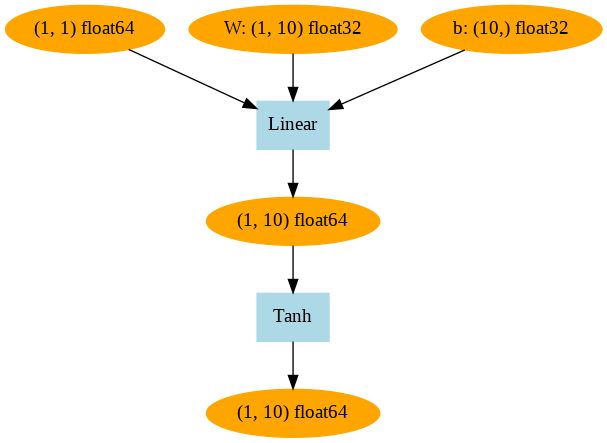

In [ ]:
import numpy as np
import dezero.layers as L
from dezero.utils import plot_dot_graph

rnn = L.RNN(10)
x = np.random.randn(1, 1)
h = rnn(x)
print(h.shape)

plot_dot_graph(h)

이 RNN을 사용해서 SimpleRNN 모델을 구성해보겠다.

In [ ]:
class SimpleRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.RNN(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    h = self.rnn(x)
    y = self.fc(h)
    return y

이제 위 SimpleRNN을 활용해서 학습을 하는 간단한 코드를 짜보자.

In [ ]:
seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:]

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
  y = model(x)
  loss += F.mean_squared_error(y, t)
  cnt += 1

  if cnt == 3:
    model.cleargrads()
    loss.backward()
    break

RNN에서의 역전파를 BPTT라고 하는데, 거슬러 올라가는 시간 개수가 많아질수록 gradient vanishing problem이 일어날 확률이 커진다. 따라서 이번에는 Truncated BPTT를 구현하기 위해 Variable 변수에 `unchain` 변수와, `unchain_backward` 함수를 추가할 것이다.

```python
class Variable:
  ...

  def unchain(self):
    self.creator = None

  def unchain_backward(self):
    if self.creator is not None:
      funcs = [self.creator]

      while funcs:
        f = funcs.pop()
        for x in f.inputs:
          if x.creator is not None:
            funcs.append(x.creator)
            x.unchain()
```

위에서 구현한 `unchain_backward()` 함수는 호출된 변수에서 시작하여, 계산 그래프를 거슬러 올라가며 마주치는 모든 변수의 `unchain` 메서드를 호출한다.

이제, 지금까지 구현한 내용으로, 노이즈가 낀 사인파 데이터를 학습하는 코드를 구현해보자. 먼저 datasets에서 노이즈가 섞인 사인 함수 데이터의 형상을 그려보자.

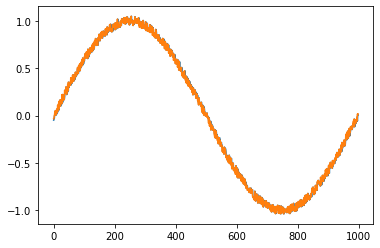

In [ ]:
import numpy as np
from dezero import datasets
import matplotlib.pyplot as plt

train_set = datasets.SinCurve(train=True)

xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [ ]:
from dezero import optimizers, datasets

max_epoch = 100
hidden_size = 100
bptt_length = 30 # BPTT 길이
train_set = datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = optimizers.Adam().setup(model)

# 학습 시작
for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x, t in train_set:
    x = x.reshape(1, 1)
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1

    if count % bptt_length == 0 or count == seqlen:
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()

  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch+1, avg_loss))


| epoch 1 | loss 0.030136
| epoch 2 | loss 0.135968
| epoch 3 | loss 0.015931
| epoch 4 | loss 0.010110
| epoch 5 | loss 0.004007
| epoch 6 | loss 0.002554
| epoch 7 | loss 0.002237
| epoch 8 | loss 0.001775
| epoch 9 | loss 0.001947
| epoch 10 | loss 0.001798
| epoch 11 | loss 0.002106
| epoch 12 | loss 0.002649
| epoch 13 | loss 0.003810
| epoch 14 | loss 0.005208
| epoch 15 | loss 0.005349
| epoch 16 | loss 0.004235
| epoch 17 | loss 0.003575
| epoch 18 | loss 0.003766
| epoch 19 | loss 0.004361
| epoch 20 | loss 0.004726
| epoch 21 | loss 0.004432
| epoch 22 | loss 0.003891
| epoch 23 | loss 0.003654
| epoch 24 | loss 0.003737
| epoch 25 | loss 0.003914
| epoch 26 | loss 0.003968
| epoch 27 | loss 0.003995
| epoch 28 | loss 0.003871
| epoch 29 | loss 0.003946
| epoch 30 | loss 0.003885
| epoch 31 | loss 0.003587
| epoch 32 | loss 0.003422
| epoch 33 | loss 0.003497
| epoch 34 | loss 0.003573
| epoch 35 | loss 0.003573
| epoch 36 | loss 0.003545
| epoch 37 | loss 0.003536
| epoch 38

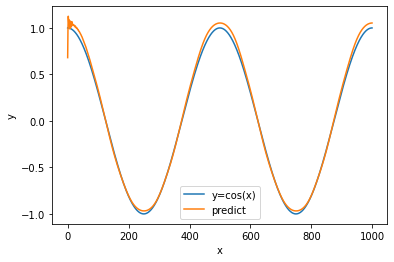

In [ ]:
import matplotlib.pyplot as plt
import dezero

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1, 1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Step 60. LSTM과 데이터로더

이번 단계에서는 시계열 데이터용 배치를 처리할 수 있는 DataLoader를 구현해보고, LSTM 신경망을 구현해서 시계열 학습을 해볼 것이다.

먼저, 시계열 데이터용 배치학습을 할 수 있는 `SeqDataLoader`를 구현해보자.

In [ ]:
class SeqDataLoader(DataLoader):
  def __init__(self, dataset, batch_size, gpu=False):
    super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, gpu=gpu)

  def __next__(self):
    if self.iteration >= self.max_iter:
      self.reset()
      raise StopIteration

    jump = self.data_size // self.batch_size
    batch_idx = [(i * jump + self.iteration) % self.data_size for i in range(self.batch_size)]
    
    xp = cuda.cupy if self.gpu else np
    x = xp.array([example[0] for example in batch])
    t = xp.array([example[1] for example in batch])

    self.iteration += 1
    return x, t

이어서 LSTM을 구현해보겠다.

In [ ]:
class LSTM(Layer):
  def __init__(self, hidden_size, in_size=None):
    super().__init__()

    H, I = hidden_size, in_size
    self.x2f = Linear(H, in_size=I)
    self.x2i = Linear(H, in_size=I)
    self.x2o = Linear(H, in_size=I)
    self.x2u = Linear(H, in_size=I)
    self.h2f = Linear(H, in_size=H, nobias=True)
    self.h2i = Linear(H, in_size=H, nobias=True)
    self.h2o = Linaer(H, in_size=H, nobias=True)
    self.h2u = Linaer(H, in_size=H, nobias=True)
    self.reset_state()

  def reset_state():
    self.h = None
    self.c = None

  def forward(self, x):
    if self.h is None:
      f = F.sigmoid(self.x2f(x))
      i = F.sigmoid(self.x2i(x))
      o = F.sigmoid(self.x2o(x))
      u = F.tanh(self.x2u(x))
    else:
      f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
      i = F.sigmoid(self.x2i(f) + self.h2i(self.h))
      o = F.sigmoid(self.x2o(f) + self.h2o(self.h))
      u = F.tanh(self.x2u(f) + self.h2u(self.h))

    if self.c is None:
      c_new = i * u
    else:
      c_new = (f * self.c) + (i * u)

    h_new = o * F.tanh(c_new)
    self.h, self.c = h_new, c_new
    return h_new

이제 위에서 구현한 LSTM 모델로 학습을 수행해보자.

In [4]:
import numpy as np
from dezero import optimizers, datasets
from dezero.models import Model
from dezero.dataloaders import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

max_epoch = 200
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)

class BetterRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.LSTM(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    y = self.rnn(x)
    y = self.fc(y)
    return y

model = BetterRNN(hidden_size, 1)
optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x, t in dataloader:
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1

    if count % bptt_length == 0 or count == seqlen:
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()

  avg_loss = float(loss.data) / count
  print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.141626
| epoch 2 | loss 0.129307
| epoch 3 | loss 0.117426
| epoch 4 | loss 0.106530
| epoch 5 | loss 0.096720
| epoch 6 | loss 0.087952
| epoch 7 | loss 0.080107
| epoch 8 | loss 0.073065
| epoch 9 | loss 0.066706
| epoch 10 | loss 0.060924
| epoch 11 | loss 0.055626
| epoch 12 | loss 0.050733
| epoch 13 | loss 0.046191
| epoch 14 | loss 0.041979
| epoch 15 | loss 0.038094
| epoch 16 | loss 0.034520
| epoch 17 | loss 0.031227
| epoch 18 | loss 0.028222
| epoch 19 | loss 0.025561
| epoch 20 | loss 0.023321
| epoch 21 | loss 0.021570
| epoch 22 | loss 0.020348
| epoch 23 | loss 0.019683
| epoch 24 | loss 0.019593
| epoch 25 | loss 0.020070
| epoch 26 | loss 0.021088
| epoch 27 | loss 0.022583
| epoch 28 | loss 0.024395
| epoch 29 | loss 0.026229
| epoch 30 | loss 0.027741
| epoch 31 | loss 0.028701
| epoch 32 | loss 0.029032
| epoch 33 | loss 0.028784
| epoch 34 | loss 0.028074
| epoch 35 | loss 0.027051
| epoch 36 | loss 0.025871
| epoch 37 | loss 0.024668
| epoch 38

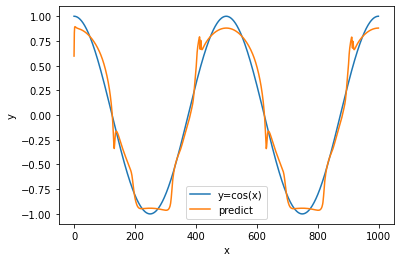

In [5]:
import matplotlib.pyplot as plt
import dezero

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1, 1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()